In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dedispersion
import filterbankio
import seaborn as sns

%matplotlib inline

In [2]:
# ASLXLAP07
#beam0buf21 = '/local/griffin/data/alfaburst/priorityModel/D20161204/Beam0_fb_D20161204T064804.buffer21.fil'
#beam0buf23 = '/local/griffin/data/alfaburst/priorityModel/D20161204/Beam0_fb_D20161204T064804.buffer23.fil'
#beam5buf4 = '/local/griffin/data/alfaburst/priorityModel/D20161204/Beam5_fb_D20161204T064804.buffer4.fil'
#B1859_03 = '/local/griffin/data/alfaburst/priorityModel/B1859+03/Beam0_fb_D20150801T220510.buffer11.fil'
#lowSNR = '/local/griffin/data/alfaburst/priorityModel/D20150730/Beam6_fb_D20150730T022011.buffer23.fil'

# watermark
beam0buf21 = '/home/griffin/data/alfa/D20161204/Beam0_fb_D20161204T064804.buffer21.fil'
beam0buf23 = '/home/griffin/data/alfa/D20161204/Beam0_fb_D20161204T064804.buffer23.fil'
beam5buf4 = '/home/griffin/data/alfa/D20161204/Beam5_fb_D20161204T064804.buffer4.fil'
B1859_03 = '/home/griffin/data/alfa/followup/B1859+03/Beam0_fb_D20150801T220510.buffer11.fil'
lowSNR = '/home/griffin/data/alfa/D20150730/Beam6_fb_D20150730T022011.buffer23.fil'

In [3]:
sns.set()
sns.set_context("paper", rc={"lines.linewidth": 1.0})

### Event (Beam 0)

In [4]:
fil = filterbankio.Filterbank(beam0buf23)
timeFactor = 16
freqFactor = 8

tInt = fil.header['tsamp'] # get tInt
freqsHz = fil.freqs * 1e6 # generate array of freqs in Hz

waterfall = np.reshape(fil.data, (fil.data.shape[0], fil.data.shape[2])) # reshape to (n integrations, n freqs)

waterfall = waterfall.reshape(waterfall.shape[0]/timeFactor, timeFactor, waterfall.shape[1]).sum(axis=1)
tInt *= timeFactor

In [5]:
dm = 293.

ddwaterfall = dedispersion.incoherent(freqsHz, waterfall, tInt, dm, boundary='wrap') # apply dedispersion

waterfall = waterfall.reshape(waterfall.shape[0], waterfall.shape[1]/freqFactor, freqFactor).sum(axis=2)
ddwaterfall = ddwaterfall.reshape(ddwaterfall.shape[0], ddwaterfall.shape[1]/freqFactor, freqFactor).sum(axis=2)
freqsHz = freqsHz[::freqFactor]

In [6]:
start_time = 1.5
time_window = 0.5

if start_time is None:
    startIdx = 0
else:
    startIdx = int(start_time / tInt)

if time_window is None:
    endIdx = waterfall.shape[0]
else:
    endIdx = startIdx + int(time_window / tInt)
    if endIdx > waterfall.shape[0]:
        print 'Warning: time window (-w) in conjunction with start time (-s) results in a window extending beyond the filterbank file, clipping to maximum size'
        endIdx = waterfall.shape[0]

timeSeries = np.sum(waterfall, axis=1)
ddTimeSeries = np.sum(ddwaterfall, axis=1)

timeSeries = timeSeries[startIdx:endIdx]
ddTimeSeries = ddTimeSeries[startIdx:endIdx]
waterfall = waterfall[startIdx:endIdx,:]
ddwaterfall = ddwaterfall[startIdx:endIdx,:]

normTimeSeries = timeSeries / (waterfall.shape[1] * timeFactor)
normDDTimeSeries = ddTimeSeries / (waterfall.shape[1] * timeFactor)

In [7]:
# Gaussian
applyGauss = True
tGauss = 1.
fGauss = 1.

def gaussianFilter(arrShape, tSigma, fSigma):
    # Gaussian filter
    # arrShape: 2-D array shape
    # tSigma: sigma in time (ms)
    # fSigma: sigma in freq (MHz)
    lpos, mpos = np.mgrid[0:arrShape[0],0:arrShape[1]]
    taper = np.exp(-1. * ( (((lpos - (arrShape[0]/2.))**2.) / (2. * tSigma**2.)) + \
                           (((mpos - (arrShape[1]/2.))**2.) / (2. * fSigma**2.)) ))
    return taper

def convolveTaper(gaussImg, img):
    return np.fft.fftshift(np.fft.ifft2(np.fft.fft2(gaussImg) * np.fft.fft2(img))).real

if applyGauss:
    gaussFilter = gaussianFilter(waterfall.shape, tGauss, fGauss)
    waterfall = convolveTaper(gaussFilter, waterfall)

In [8]:
# flatten bandpass
bandpass = np.tile(waterfall.mean(axis=0).reshape(-1, 1), waterfall.shape[0]).T
#bandpass = np.tile(waterfall[80:].mean(axis=0).reshape(-1, 1), waterfall.shape[0]).T
#bandpass = np.tile(waterfall[:10].mean(axis=0).reshape(-1, 1), waterfall.shape[0]).T
waterfallNorm = waterfall - bandpass
#waterfallNorm = waterfall

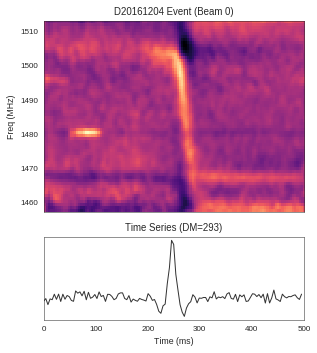

In [9]:
cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(4.5,5)) # (width, height)

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3, rowspan=2)
#plt.subplot(2,1,1)
imRaw = plt.imshow(np.flipud(waterfallNorm.T), extent=(0, tInt*waterfall.shape[0], fil.freqs[0], fil.freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')
#imRaw = plt.imshow(np.flipud(bandpass.T), extent=(0, tInt*waterfall.shape[0], fil.freqs[0], fil.freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

plt.title('D20161204 Event (Beam 0)')
plt.ylabel('Freq (MHz)')
#cax = fig.add_axes([0.75, .95, 0.15, 0.03])
#cbar = fig.colorbar(imRaw, cax=cax, orientation='horizontal')
#cbar.ax.set_xticklabels(cbar.ax.get_xticklabels(), rotation='vertical', fontsize=8)
ax1.get_xaxis().set_visible(False)

ax2 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
#plt.subplot(2,1,2)
lineColor = 'k'
plt.plot(tInt * np.arange(waterfall.shape[0]) * 1000., normDDTimeSeries, lineColor, alpha=0.8)
plt.xlim(0, tInt * timeSeries.shape[0] * 1000.)
plt.title('Time Series (DM=%0.f)'%dm)
plt.xlabel('Time (ms)')
ax2.get_yaxis().set_visible(False)
#plt.ylabel('Amp')

#plt.subplots_adjust(hspace=-0.3)
plt.tight_layout()

plt.savefig('../figures/D20161204_buf23_Beam0.pdf')

### Event (Beam 0, Wide)

In [10]:
fil = filterbankio.Filterbank(beam0buf23)
timeFactor = 16
freqFactor = 8

tInt = fil.header['tsamp'] # get tInt
freqsHz = fil.freqs * 1e6 # generate array of freqs in Hz

waterfall = np.reshape(fil.data, (fil.data.shape[0], fil.data.shape[2])) # reshape to (n integrations, n freqs)

waterfall = waterfall.reshape(waterfall.shape[0]/timeFactor, timeFactor, waterfall.shape[1]).sum(axis=1)
tInt *= timeFactor

In [11]:
dm = 293.

ddwaterfall = dedispersion.incoherent(freqsHz, waterfall, tInt, dm, boundary='wrap') # apply dedispersion

waterfall = waterfall.reshape(waterfall.shape[0], waterfall.shape[1]/freqFactor, freqFactor).sum(axis=2)
ddwaterfall = ddwaterfall.reshape(ddwaterfall.shape[0], ddwaterfall.shape[1]/freqFactor, freqFactor).sum(axis=2)
freqsHz = freqsHz[::freqFactor]

In [12]:
start_time = 0.1
time_window = 3.3

if start_time is None:
    startIdx = 0
else:
    startIdx = int(start_time / tInt)

if time_window is None:
    endIdx = waterfall.shape[0]
else:
    endIdx = startIdx + int(time_window / tInt)
    if endIdx > waterfall.shape[0]:
        print 'Warning: time window (-w) in conjunction with start time (-s) results in a window extending beyond the filterbank file, clipping to maximum size'
        endIdx = waterfall.shape[0]

timeSeries = np.sum(waterfall, axis=1)
ddTimeSeries = np.sum(ddwaterfall, axis=1)

timeSeries = timeSeries[startIdx:endIdx]
ddTimeSeries = ddTimeSeries[startIdx:endIdx]
waterfall = waterfall[startIdx:endIdx,:]
ddwaterfall = ddwaterfall[startIdx:endIdx,:]

normTimeSeries = timeSeries / (waterfall.shape[1] * timeFactor)
normDDTimeSeries = ddTimeSeries / (waterfall.shape[1] * timeFactor)

In [13]:
# Gaussian
applyGauss = True
tGauss = 1.
fGauss = 1.

def gaussianFilter(arrShape, tSigma, fSigma):
    # Gaussian filter
    # arrShape: 2-D array shape
    # tSigma: sigma in time (ms)
    # fSigma: sigma in freq (MHz)
    lpos, mpos = np.mgrid[0:arrShape[0],0:arrShape[1]]
    taper = np.exp(-1. * ( (((lpos - (arrShape[0]/2.))**2.) / (2. * tSigma**2.)) + \
                           (((mpos - (arrShape[1]/2.))**2.) / (2. * fSigma**2.)) ))
    return taper

def convolveTaper(gaussImg, img):
    return np.fft.fftshift(np.fft.ifft2(np.fft.fft2(gaussImg) * np.fft.fft2(img))).real

if applyGauss:
    gaussFilter = gaussianFilter(waterfall.shape, tGauss, fGauss)
    waterfall = convolveTaper(gaussFilter, waterfall)

In [14]:
# flatten bandpass
bandpass = np.tile(waterfall.mean(axis=0).reshape(-1, 1), waterfall.shape[0]).T
#bandpass = np.tile(waterfall[80:].mean(axis=0).reshape(-1, 1), waterfall.shape[0]).T
#bandpass = np.tile(waterfall[:10].mean(axis=0).reshape(-1, 1), waterfall.shape[0]).T
waterfallNorm = waterfall - bandpass
#waterfallNorm = waterfall

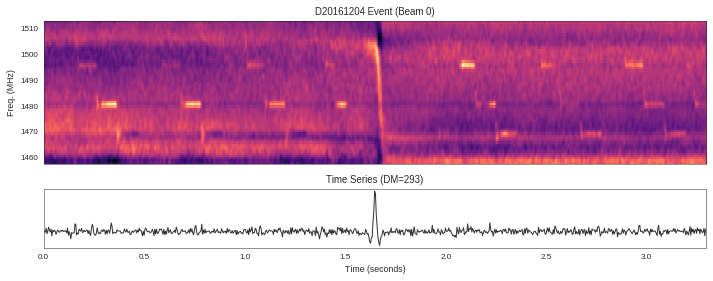

In [15]:
cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(10,4)) # (width, height)

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3, rowspan=2)
#plt.subplot(2,1,1)
imRaw = plt.imshow(np.flipud(waterfallNorm.T), extent=(0, tInt*waterfall.shape[0], fil.freqs[0], fil.freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')
#imRaw = plt.imshow(np.flipud(bandpass.T), extent=(0, tInt*waterfall.shape[0], fil.freqs[0], fil.freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

plt.title('D20161204 Event (Beam 0)')
plt.ylabel('Freq. (MHz)')
#cax = fig.add_axes([0.75, .95, 0.15, 0.03])
#cbar = fig.colorbar(imRaw, cax=cax, orientation='horizontal')
#cbar.ax.set_xticklabels(cbar.ax.get_xticklabels(), rotation='vertical', fontsize=8)
ax1.get_xaxis().set_visible(False)

ax2 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
#plt.subplot(2,1,2)
lineColor = 'k'
plt.plot(tInt*np.arange(waterfall.shape[0]), normDDTimeSeries, lineColor, alpha=0.8)
plt.xlim(0, tInt*timeSeries.shape[0])
plt.title('Time Series (DM=%0.f)'%dm)
plt.xlabel('Time (seconds)')
ax2.get_yaxis().set_visible(False)
#plt.ylabel('Amp')

#plt.subplots_adjust(hspace=-0.3)
plt.tight_layout()

plt.savefig('../figures/D20161204_buf23_Beam0_wide.pdf')

### Event (Beam 5)

In [16]:
fil = filterbankio.Filterbank(beam5buf4)
timeFactor = 16
freqFactor = 8

tInt = fil.header['tsamp'] # get tInt
freqsHz = fil.freqs * 1e6 # generate array of freqs in Hz

waterfall = np.reshape(fil.data, (fil.data.shape[0], fil.data.shape[2])) # reshape to (n integrations, n freqs)

waterfall = waterfall.reshape(waterfall.shape[0]/timeFactor, timeFactor, waterfall.shape[1]).sum(axis=1)
tInt *= timeFactor

In [17]:
dm = 293.

ddwaterfall = dedispersion.incoherent(freqsHz, waterfall, tInt, dm, boundary='wrap') # apply dedispersion

waterfall = waterfall.reshape(waterfall.shape[0], waterfall.shape[1]/freqFactor, freqFactor).sum(axis=2)
ddwaterfall = ddwaterfall.reshape(ddwaterfall.shape[0], ddwaterfall.shape[1]/freqFactor, freqFactor).sum(axis=2)
freqsHz = freqsHz[::freqFactor]

In [18]:
start_time = 3.625
time_window = 0.5

if start_time is None:
    startIdx = 0
else:
    startIdx = int(start_time / tInt)

if time_window is None:
    endIdx = waterfall.shape[0]
else:
    endIdx = startIdx + int(time_window / tInt)
    if endIdx > waterfall.shape[0]:
        print 'Warning: time window (-w) in conjunction with start time (-s) results in a window extending beyond the filterbank file, clipping to maximum size'
        endIdx = waterfall.shape[0]

timeSeries = np.sum(waterfall, axis=1)
ddTimeSeries = np.sum(ddwaterfall, axis=1)

timeSeries = timeSeries[startIdx:endIdx]
ddTimeSeries = ddTimeSeries[startIdx:endIdx]
waterfall = waterfall[startIdx:endIdx,:]
ddwaterfall = ddwaterfall[startIdx:endIdx,:]

normTimeSeries = timeSeries / (waterfall.shape[1] * timeFactor)
normDDTimeSeries = ddTimeSeries / (waterfall.shape[1] * timeFactor)

In [19]:
# Gaussian
applyGauss = True
tGauss = 1.
fGauss = 1.

def gaussianFilter(arrShape, tSigma, fSigma):
    # Gaussian filter
    # arrShape: 2-D array shape
    # tSigma: sigma in time (ms)
    # fSigma: sigma in freq (MHz)
    lpos, mpos = np.mgrid[0:arrShape[0],0:arrShape[1]]
    taper = np.exp(-1. * ( (((lpos - (arrShape[0]/2.))**2.) / (2. * tSigma**2.)) + \
                           (((mpos - (arrShape[1]/2.))**2.) / (2. * fSigma**2.)) ))
    return taper

def convolveTaper(gaussImg, img):
    return np.fft.fftshift(np.fft.ifft2(np.fft.fft2(gaussImg) * np.fft.fft2(img))).real

if applyGauss:
    gaussFilter = gaussianFilter(waterfall.shape, tGauss, fGauss)
    waterfall = convolveTaper(gaussFilter, waterfall)

In [20]:
# flatten bandpass
bandpass = np.tile(waterfall.mean(axis=0).reshape(-1, 1), waterfall.shape[0]).T
waterfallNorm = waterfall - bandpass

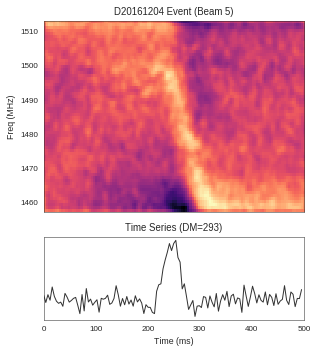

In [21]:
cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(4.5,5)) # (width, height)

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3, rowspan=2)
#plt.subplot(2,1,1)
imRaw = plt.imshow(np.flipud(waterfallNorm.T), extent=(0, tInt*waterfall.shape[0], fil.freqs[0], fil.freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')
#imRaw = plt.imshow(np.flipud(bandpass.T), extent=(0, tInt*waterfall.shape[0], fil.freqs[0], fil.freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

plt.title('D20161204 Event (Beam 5)')
plt.ylabel('Freq (MHz)')
#cax = fig.add_axes([0.75, .95, 0.15, 0.03])
#cbar = fig.colorbar(imRaw, cax=cax, orientation='horizontal')
#cbar.ax.set_xticklabels(cbar.ax.get_xticklabels(), rotation='vertical', fontsize=8)
ax1.get_xaxis().set_visible(False)

ax2 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
#plt.subplot(2,1,2)
lineColor = 'k'
plt.plot(tInt * np.arange(waterfall.shape[0]) * 1000., normDDTimeSeries, lineColor, alpha=0.8)
plt.xlim(0, tInt * timeSeries.shape[0] * 1000.)
plt.title('Time Series (DM=%0.f)'%dm)
plt.xlabel('Time (ms)')
ax2.get_yaxis().set_visible(False)
#plt.ylabel('Amp')

#plt.subplots_adjust(hspace=-0.3)
plt.tight_layout()

plt.savefig('../figures/D20161204_buf4_Beam5.pdf')

### Bandpasses

In [22]:
beam0fil = filterbankio.Filterbank(beam0buf23)
beam5fil = filterbankio.Filterbank(beam5buf4)
b1859fil = filterbankio.Filterbank(B1859_03)

beam0waterfall = np.reshape(beam0fil.data, (beam0fil.data.shape[0], beam0fil.data.shape[2])) # reshape to (n integrations, n freqs)
beam5waterfall = np.reshape(beam5fil.data, (beam5fil.data.shape[0], beam5fil.data.shape[2])) # reshape to (n integrations, n freqs)
stdwaterfall = np.reshape(b1859fil.data, (b1859fil.data.shape[0], b1859fil.data.shape[2])) # reshape to (n integrations, n freqs)

beam0bp = beam0waterfall.mean(axis=0)
beam5bp = beam5waterfall.mean(axis=0)
stdbp = stdwaterfall.mean(axis=0)

freqsMHz = beam0fil.freqs

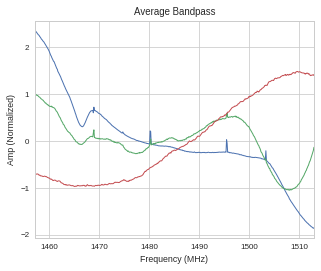

In [23]:
sns.set_style('whitegrid')
fig = plt.figure(figsize=(5,4)) # (width, height)

plt.plot(freqsMHz, beam0bp)
plt.plot(freqsMHz, beam5bp)
plt.plot(freqsMHz, stdbp)
plt.xlim(freqsMHz[0], freqsMHz[-1])
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amp (Normalized)')
plt.title('Average Bandpass')

plt.savefig('../figures/bandpass_response.pdf')

### PLL

In [24]:
fil = filterbankio.Filterbank(beam0buf23)
timeFactor = 1
freqFactor = 2

tInt = fil.header['tsamp'] # get tInt
freqsHz = fil.freqs * 1e6 # generate array of freqs in Hz

waterfall = np.reshape(fil.data, (fil.data.shape[0], fil.data.shape[2])) # reshape to (n integrations, n freqs)

waterfall = waterfall.reshape(waterfall.shape[0]/timeFactor, timeFactor, waterfall.shape[1]).sum(axis=1)
tInt *= timeFactor

waterfall = waterfall.reshape(waterfall.shape[0], waterfall.shape[1]/freqFactor, freqFactor).sum(axis=2)

In [25]:
# flatten bandpass
bandpass = np.tile(waterfall.mean(axis=0).reshape(-1, 1), waterfall.shape[0]).T
waterfall = waterfall - bandpass

#print np.min(waterfall), np.max(waterfall)
#waterfall = np.clip((waterfall - np.min(waterfall)), 4.5, np.max(waterfall))

In [26]:
#start_time = 2.975
#time_window = 0.32
start_time = 3.05
time_window = 0.16

if start_time is None:
    startIdx = 0
else:
    startIdx = int(start_time / tInt)

if time_window is None:
    endIdx = waterfall.shape[0]
else:
    endIdx = startIdx + int(time_window / tInt)
    if endIdx > waterfall.shape[0]:
        print 'Warning: time window (-w) in conjunction with start time (-s) results in a window extending beyond the filterbank file, clipping to maximum size'
        endIdx = waterfall.shape[0]

waterfall = waterfall[startIdx:endIdx,:]

#waterfall = waterfall[:, 0:230]

In [27]:
# Gaussian
applyGauss = True
tGauss = 1.
fGauss = 1.

def gaussianFilter(arrShape, tSigma, fSigma):
    # Gaussian filter
    # arrShape: 2-D array shape
    # tSigma: sigma in time (ms)
    # fSigma: sigma in freq (MHz)
    lpos, mpos = np.mgrid[0:arrShape[0],0:arrShape[1]]
    taper = np.exp(-1. * ( (((lpos - (arrShape[0]/2.))**2.) / (2. * tSigma**2.)) + \
                           (((mpos - (arrShape[1]/2.))**2.) / (2. * fSigma**2.)) ))
    return taper

def convolveTaper(gaussImg, img):
    return np.fft.fftshift(np.fft.ifft2(np.fft.fft2(gaussImg) * np.fft.fft2(img))).real

if applyGauss:
    gaussFilter = gaussianFilter(waterfall.shape, tGauss, fGauss)
    waterfall = convolveTaper(gaussFilter, waterfall)

In [28]:
waterfallScaled = waterfall - waterfall.min()
waterfallScaled = waterfallScaled**(1.5)

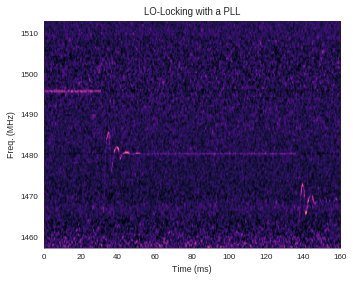

In [29]:
cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

#fig = plt.figure(figsize=(8,4)) # (width, height)
fig = plt.figure(figsize=(5,4)) # (width, height)

#ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3, rowspan=2)
#plt.subplot(2,1,1)
imRaw = plt.imshow(np.flipud(waterfallScaled.T), extent=(0, tInt*waterfall.shape[0]*1000., fil.freqs[0], fil.freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')
#imRaw = plt.imshow(np.flipud(bandpass.T), extent=(0, tInt*waterfall.shape[0], fil.freqs[0], fil.freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

plt.title('')
plt.ylabel('Freq. (MHz)')
#cax = fig.add_axes([0.75, .95, 0.15, 0.03])
#cbar = fig.colorbar(imRaw, cax=cax, orientation='horizontal')
#cbar.ax.set_xticklabels(cbar.ax.get_xticklabels(), rotation='vertical', fontsize=8)
#ax1.get_xaxis().set_visible(False)
plt.xlabel('Time (ms)')
plt.title('LO-Locking with a PLL')

#plt.subplots_adjust(hspace=-0.3)
plt.tight_layout()

plt.savefig('../figures/pll_spectrum.pdf')

### Event (DM - Time) (Beam 0)

In [30]:
fil = filterbankio.Filterbank(beam0buf23)
timeFactor = 16
#fil = filterbankio.Filterbank(lowSNR)
#timeFactor = 8

tInt = fil.header['tsamp'] # get tInt
freqsHz = fil.freqs * 1e6 # generate array of freqs in Hz

waterfall = np.reshape(fil.data, (fil.data.shape[0], fil.data.shape[2])) # reshape to (n integrations, n freqs)

waterfall = waterfall.reshape(waterfall.shape[0]/timeFactor, timeFactor, waterfall.shape[1]).sum(axis=1)
tInt *= timeFactor

In [31]:
start_time = 1
time_window = 1.5
minDM = 0
maxDM = 1600
dmStep = 4

if start_time is None:
    startIdx = 0
else:
    startIdx = int(start_time / tInt)

if time_window is None:
    endIdx = waterfall.shape[0]
else:
    endIdx = startIdx + int(time_window / tInt)
    if endIdx > waterfall.shape[0]:
        print 'Warning: time window (-w) in conjunction with start time (-s) results in a window extending beyond the filterbank file, clipping to maximum size'
        endIdx = waterfall.shape[0]

waterfall = waterfall[startIdx:endIdx,:]
testDMs = np.arange(minDM, maxDM, dmStep)

dmSpace = np.zeros((testDMs.shape[0], waterfall.shape[0]))
print dmSpace.shape
for dmid, dm in enumerate(testDMs):
    dmSpace[dmid, :] = np.sum(dedispersion.incoherent(freqsHz, waterfall, tInt, dm, boundary='wrap'), axis=1)

(400, 366)


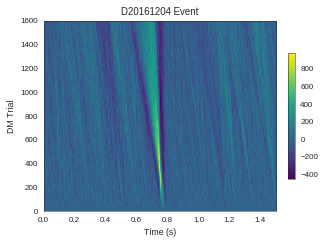

In [32]:
cmap = 'viridis'
fig = plt.figure(figsize=(4.5,3.5)) # (width, height)
#fig = plt.figure(figsize=(8,4)) # (width, height)

plt.imshow(np.flipud(dmSpace), aspect='auto', extent=(0, tInt * waterfall.shape[0], testDMs[0], testDMs[-1]), cmap=plt.get_cmap(cmap), interpolation='nearest')
plt.ylabel('DM Trial')
plt.xlabel('Time (s)')
plt.colorbar(fraction=0.025)
plt.title('D20161204 Event')

plt.savefig('../figures/D20161204_dmtrials_buf23_Beam0.pdf')

### Event (DM - Time) (Beam 5)

In [33]:
#fil = filterbankio.Filterbank(beam5buf4)
fil = filterbankio.Filterbank(beam0buf21)
timeFactor = 16

tInt = fil.header['tsamp'] # get tInt
freqsHz = fil.freqs * 1e6 # generate array of freqs in Hz

waterfall = np.reshape(fil.data, (fil.data.shape[0], fil.data.shape[2])) # reshape to (n integrations, n freqs)

waterfall = waterfall.reshape(waterfall.shape[0]/timeFactor, timeFactor, waterfall.shape[1]).sum(axis=1)
tInt *= timeFactor

In [34]:
start_time = 1
time_window = 6
minDM = -1600
maxDM = 1600
dmStep = 8

if start_time is None:
    startIdx = 0
else:
    startIdx = int(start_time / tInt)

if time_window is None:
    endIdx = waterfall.shape[0]
else:
    endIdx = startIdx + int(time_window / tInt)
    if endIdx > waterfall.shape[0]:
        print 'Warning: time window (-w) in conjunction with start time (-s) results in a window extending beyond the filterbank file, clipping to maximum size'
        endIdx = waterfall.shape[0]

waterfall = waterfall[startIdx:endIdx,:]
testDMs = np.arange(minDM, maxDM, dmStep)

dmSpace = np.zeros((testDMs.shape[0], waterfall.shape[0]))
print dmSpace.shape
for dmid, dm in enumerate(testDMs):
    dmSpace[dmid, :] = np.sum(dedispersion.incoherent(freqsHz, waterfall, tInt, dm, boundary='wrap'), axis=1)

(400, 1464)


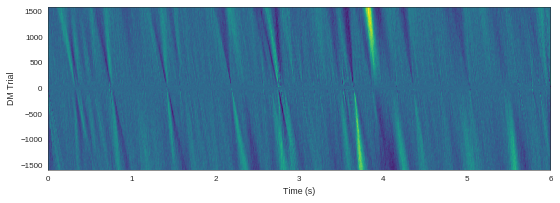

In [35]:
cmap = 'viridis'
#fig = plt.figure(figsize=(4,3)) # (width, height)
fig = plt.figure(figsize=(9,3)) # (width, height)

plt.imshow(np.flipud(dmSpace), aspect='auto', extent=(0, tInt*waterfall.shape[0], testDMs[0], testDMs[-1]), cmap=plt.get_cmap(cmap), interpolation='nearest')
plt.ylabel('DM Trial')
plt.xlabel('Time (s)')
#plt.colorbar(fraction=0.025)
#plt.title('D20161204 Event')
plt.savefig('../figures/D20161204_dmtrials_buf21_Beam0.pdf')

In [36]:
# Gaussian
applyGauss = False
tGauss = 1.
fGauss = 1.

def gaussianFilter(arrShape, tSigma, fSigma):
    # Gaussian filter
    # arrShape: 2-D array shape
    # tSigma: sigma in time (ms)
    # fSigma: sigma in freq (MHz)
    lpos, mpos = np.mgrid[0:arrShape[0],0:arrShape[1]]
    taper = np.exp(-1. * ( (((lpos - (arrShape[0]/2.))**2.) / (2. * tSigma**2.)) + \
                           (((mpos - (arrShape[1]/2.))**2.) / (2. * fSigma**2.)) ))
    return taper

def convolveTaper(gaussImg, img):
    return np.fft.fftshift(np.fft.ifft2(np.fft.fft2(gaussImg) * np.fft.fft2(img))).real

if applyGauss:
    gaussFilter = gaussianFilter(waterfall.shape, tGauss, fGauss)
    waterfall = convolveTaper(gaussFilter, waterfall)

In [37]:
# flatten bandpass
bandpass = np.tile(waterfall[:100].mean(axis=0).reshape(-1, 1), waterfall.shape[0]).T
waterfallNorm = waterfall - bandpass

In [38]:
print waterfallNorm.max(), waterfallNorm.min()
waterfallScaled = waterfallNorm - waterfallNorm.min()
print waterfallScaled.max()
waterfallScaled = np.clip(waterfallScaled, 0, 50)

59.0413 -26.7043
85.7456


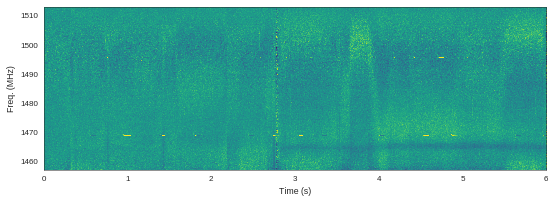

In [39]:
cmap = 'viridis'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(9,3)) # (width, height)

imRaw = plt.imshow(np.flipud(waterfallScaled.T), extent=(0, tInt*waterfall.shape[0], fil.freqs[0], fil.freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

#plt.title('D20161204 - 80 s')
plt.ylabel('Freq. (MHz)')
plt.xlabel('Time (s)')
plt.savefig('../figures/D20161204_spect_buf21_Beam0.pdf')

### B1859+03 (DM - Time)

In [40]:
fil = filterbankio.Filterbank(B1859_03)
timeFactor = 8

tInt = fil.header['tsamp'] # get tInt
freqsHz = fil.freqs * 1e6 # generate array of freqs in Hz

waterfall = np.reshape(fil.data, (fil.data.shape[0], fil.data.shape[2])) # reshape to (n integrations, n freqs)

waterfall = waterfall.reshape(waterfall.shape[0]/timeFactor, timeFactor, waterfall.shape[1]).sum(axis=1)
tInt *= timeFactor

In [41]:
start_time = 3.3
time_window = 1.5
minDM = 0
maxDM = 2000
dmStep = 4

if start_time is None:
    startIdx = 0
else:
    startIdx = int(start_time / tInt)

if time_window is None:
    endIdx = waterfall.shape[0]
else:
    endIdx = startIdx + int(time_window / tInt)
    if endIdx > waterfall.shape[0]:
        print 'Warning: time window (-w) in conjunction with start time (-s) results in a window extending beyond the filterbank file, clipping to maximum size'
        endIdx = waterfall.shape[0]

waterfall = waterfall[startIdx:endIdx,:]
testDMs = np.arange(minDM, maxDM, dmStep)

dmSpace = np.zeros((testDMs.shape[0], waterfall.shape[0]))
print dmSpace.shape
for dmid, dm in enumerate(testDMs):
    dmSpace[dmid, :] = np.sum(dedispersion.incoherent(freqsHz, waterfall, tInt, dm, boundary='wrap'), axis=1)

(500, 732)


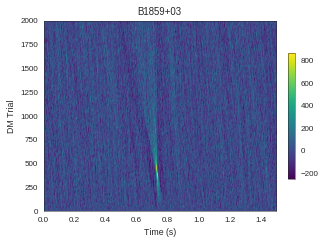

In [42]:
cmap = 'viridis'
fig = plt.figure(figsize=(4.5,3.5)) # (width, height)
#fig = plt.figure(figsize=(8,4)) # (width, height)

plt.imshow(np.flipud(dmSpace), aspect='auto', extent=(0, tInt*waterfall.shape[0], testDMs[0], testDMs[-1]), cmap=plt.get_cmap(cmap), interpolation='nearest')
plt.ylabel('DM Trial')
plt.xlabel('Time (s)')
plt.colorbar(fraction=0.025)
plt.title('B1859+03')

plt.savefig('../figures/B1859_dmtrials.pdf')

### D20150730 (low-SNR)

In [43]:
fil = filterbankio.Filterbank(lowSNR)
timeFactor = 8
freqFactor = 8

tInt = fil.header['tsamp'] # get tInt
freqsHz = fil.freqs * 1e6 # generate array of freqs in Hz

waterfall = np.reshape(fil.data, (fil.data.shape[0], fil.data.shape[2])) # reshape to (n integrations, n freqs)

waterfall = waterfall.reshape(waterfall.shape[0]/timeFactor, timeFactor, waterfall.shape[1]).sum(axis=1)
tInt *= timeFactor

In [44]:
dm = 1370.

ddwaterfall = dedispersion.incoherent(freqsHz, waterfall, tInt, dm, boundary='wrap') # apply dedispersion

waterfall = waterfall.reshape(waterfall.shape[0], waterfall.shape[1]/freqFactor, freqFactor).sum(axis=2)
ddwaterfall = ddwaterfall.reshape(ddwaterfall.shape[0], ddwaterfall.shape[1]/freqFactor, freqFactor).sum(axis=2)
freqsHz = freqsHz[::freqFactor]

In [45]:
start_time = 7.2
time_window = 0.6

if start_time is None:
    startIdx = 0
else:
    startIdx = int(start_time / tInt)

if time_window is None:
    endIdx = waterfall.shape[0]
else:
    endIdx = startIdx + int(time_window / tInt)
    if endIdx > waterfall.shape[0]:
        print 'Warning: time window (-w) in conjunction with start time (-s) results in a window extending beyond the filterbank file, clipping to maximum size'
        endIdx = waterfall.shape[0]

timeSeries = np.sum(waterfall, axis=1)
ddTimeSeries = np.sum(ddwaterfall, axis=1)

timeSeries = timeSeries[startIdx:endIdx]
ddTimeSeries = ddTimeSeries[startIdx:endIdx]
waterfall = waterfall[startIdx:endIdx,:]
ddwaterfall = ddwaterfall[startIdx:endIdx,:]

normTimeSeries = timeSeries / (waterfall.shape[1] * timeFactor)
normDDTimeSeries = ddTimeSeries / (waterfall.shape[1] * timeFactor)

In [46]:
# flatten bandpass
bandpass = np.tile(waterfall.mean(axis=0).reshape(-1, 1), waterfall.shape[0]).T
waterfallNorm = waterfall - bandpass
#waterfallNorm = waterfall

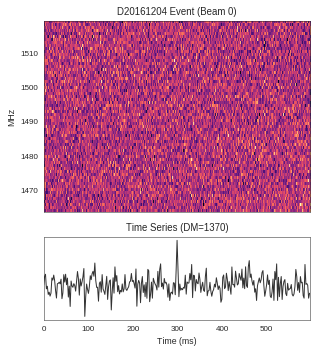

In [47]:
cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(4.5,5)) # (width, height)

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3, rowspan=2)
#plt.subplot(2,1,1)
imRaw = plt.imshow(np.flipud(waterfallNorm.T), extent=(0, tInt*waterfall.shape[0], fil.freqs[0], fil.freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')
#imRaw = plt.imshow(np.flipud(bandpass.T), extent=(0, tInt*waterfall.shape[0], fil.freqs[0], fil.freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

plt.title('D20161204 Event (Beam 0)')
plt.ylabel('MHz')
#cax = fig.add_axes([0.75, .95, 0.15, 0.03])
#cbar = fig.colorbar(imRaw, cax=cax, orientation='horizontal')
#cbar.ax.set_xticklabels(cbar.ax.get_xticklabels(), rotation='vertical', fontsize=8)
ax1.get_xaxis().set_visible(False)

ax2 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
#plt.subplot(2,1,2)
lineColor = 'k'
plt.plot(tInt * np.arange(waterfall.shape[0]) * 1000., normDDTimeSeries, lineColor, alpha=0.8)
plt.xlim(0, tInt * timeSeries.shape[0] * 1000.)
plt.title('Time Series (DM=%0.f)'%dm)
plt.xlabel('Time (ms)')
ax2.get_yaxis().set_visible(False)
#plt.ylabel('Amp')

#plt.subplots_adjust(hspace=-0.3)
plt.tight_layout()

plt.savefig('../figures/D20150730_buf23_Beam6.pdf')

### D20150730 (low-SNR, DM-space)

In [48]:
fil = filterbankio.Filterbank(lowSNR)
timeFactor = 8

tInt = fil.header['tsamp'] # get tInt
freqsHz = fil.freqs * 1e6 # generate array of freqs in Hz

waterfall = np.reshape(fil.data, (fil.data.shape[0], fil.data.shape[2])) # reshape to (n integrations, n freqs)

waterfall = waterfall.reshape(waterfall.shape[0]/timeFactor, timeFactor, waterfall.shape[1]).sum(axis=1)
tInt *= timeFactor

In [49]:
start_time = 7.2
time_window = 0.6
minDM = 1000
maxDM = 2000
dmStep = 2

if start_time is None:
    startIdx = 0
else:
    startIdx = int(start_time / tInt)

if time_window is None:
    endIdx = waterfall.shape[0]
else:
    endIdx = startIdx + int(time_window / tInt)
    if endIdx > waterfall.shape[0]:
        print 'Warning: time window (-w) in conjunction with start time (-s) results in a window extending beyond the filterbank file, clipping to maximum size'
        endIdx = waterfall.shape[0]

waterfall = waterfall[startIdx:endIdx,:]
testDMs = np.arange(minDM, maxDM, dmStep)

dmSpace = np.zeros((testDMs.shape[0], waterfall.shape[0]))
print dmSpace.shape
for dmid, dmi in enumerate(testDMs):
    dmSpace[dmid, :] = np.sum(dedispersion.incoherent(freqsHz, waterfall, tInt, dmi, boundary='wrap'), axis=1)

(500, 292)


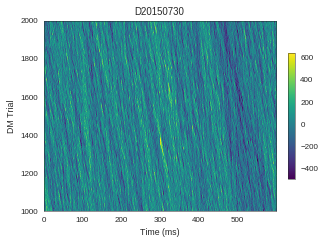

In [50]:
cmap = 'viridis'
fig = plt.figure(figsize=(4.5,3.5)) # (width, height)
#fig = plt.figure(figsize=(8,4)) # (width, height)

plt.imshow(np.flipud(dmSpace), aspect='auto', extent=(0, tInt * waterfall.shape[0] * 1000., testDMs[0], testDMs[-1]), cmap=plt.get_cmap(cmap), interpolation='nearest')
plt.ylabel('DM Trial')
plt.xlabel('Time (ms)')
plt.colorbar(fraction=0.025)
plt.title('D20150730')

plt.savefig('../figures/D20150730_dmtrials.pdf')

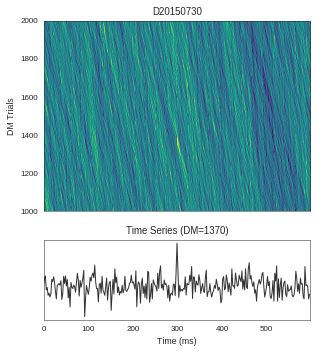

In [51]:
cmap = 'viridis'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(4.5,5)) # (width, height)

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3, rowspan=2)
#plt.subplot(2,1,1)
#imRaw = plt.imshow(np.flipud(waterfallNorm.T), extent=(0, tInt*waterfall.shape[0], fil.freqs[0], fil.freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')
#imRaw = plt.imshow(np.flipud(bandpass.T), extent=(0, tInt*waterfall.shape[0], fil.freqs[0], fil.freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

#plt.title('D20161204 Event (Beam 0)')
#plt.ylabel('MHz')
#cax = fig.add_axes([0.75, .95, 0.15, 0.03])
#cbar = fig.colorbar(imRaw, cax=cax, orientation='horizontal')
#cbar.ax.set_xticklabels(cbar.ax.get_xticklabels(), rotation='vertical', fontsize=8)

imRaw = plt.imshow(np.flipud(dmSpace), aspect='auto', extent=(0, tInt*waterfall.shape[0], testDMs[0], testDMs[-1]), cmap=plt.get_cmap(cmap), interpolation='nearest')
plt.ylabel('DM Trials')
#plt.colorbar(fraction=0.025)
plt.title('D20150730')

ax1.get_xaxis().set_visible(False)

ax2 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
#plt.subplot(2,1,2)
lineColor = 'k'
plt.plot(tInt * np.arange(normDDTimeSeries.shape[0]) * 1000., normDDTimeSeries, lineColor, alpha=0.8)
plt.xlim(0, tInt * timeSeries.shape[0] * 1000.)
plt.title('Time Series (DM=%0.f)'%dm)
plt.xlabel('Time (ms)')
ax2.get_yaxis().set_visible(False)
#plt.ylabel('Amp')

#plt.subplots_adjust(hspace=-0.3)
plt.tight_layout()

plt.savefig('../figures/D20150730_buf23_Beam6_dmtrial.pdf')